# Bayesian optimization
In this practical, we write a class for Gaussian process-based Bayesian optimization. 

ID : put data generation and class in py file, make them do both marginal likelihood with sklearn and full Bayesian using pymc3 (hence the rest without sklearn?)?

In [6]:
# make sure the notebook reloads the module each time we modify it
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Import material for this particular practical. You will have to modify this module.
import nonparametric_regression as nr 

# Make plots look nice
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")

# Import generic libraries
import numpy as np
import numpy.random as npr
import time

# Make plots interactive
%matplotlib notebook

<IPython.core.display.Javascript object>


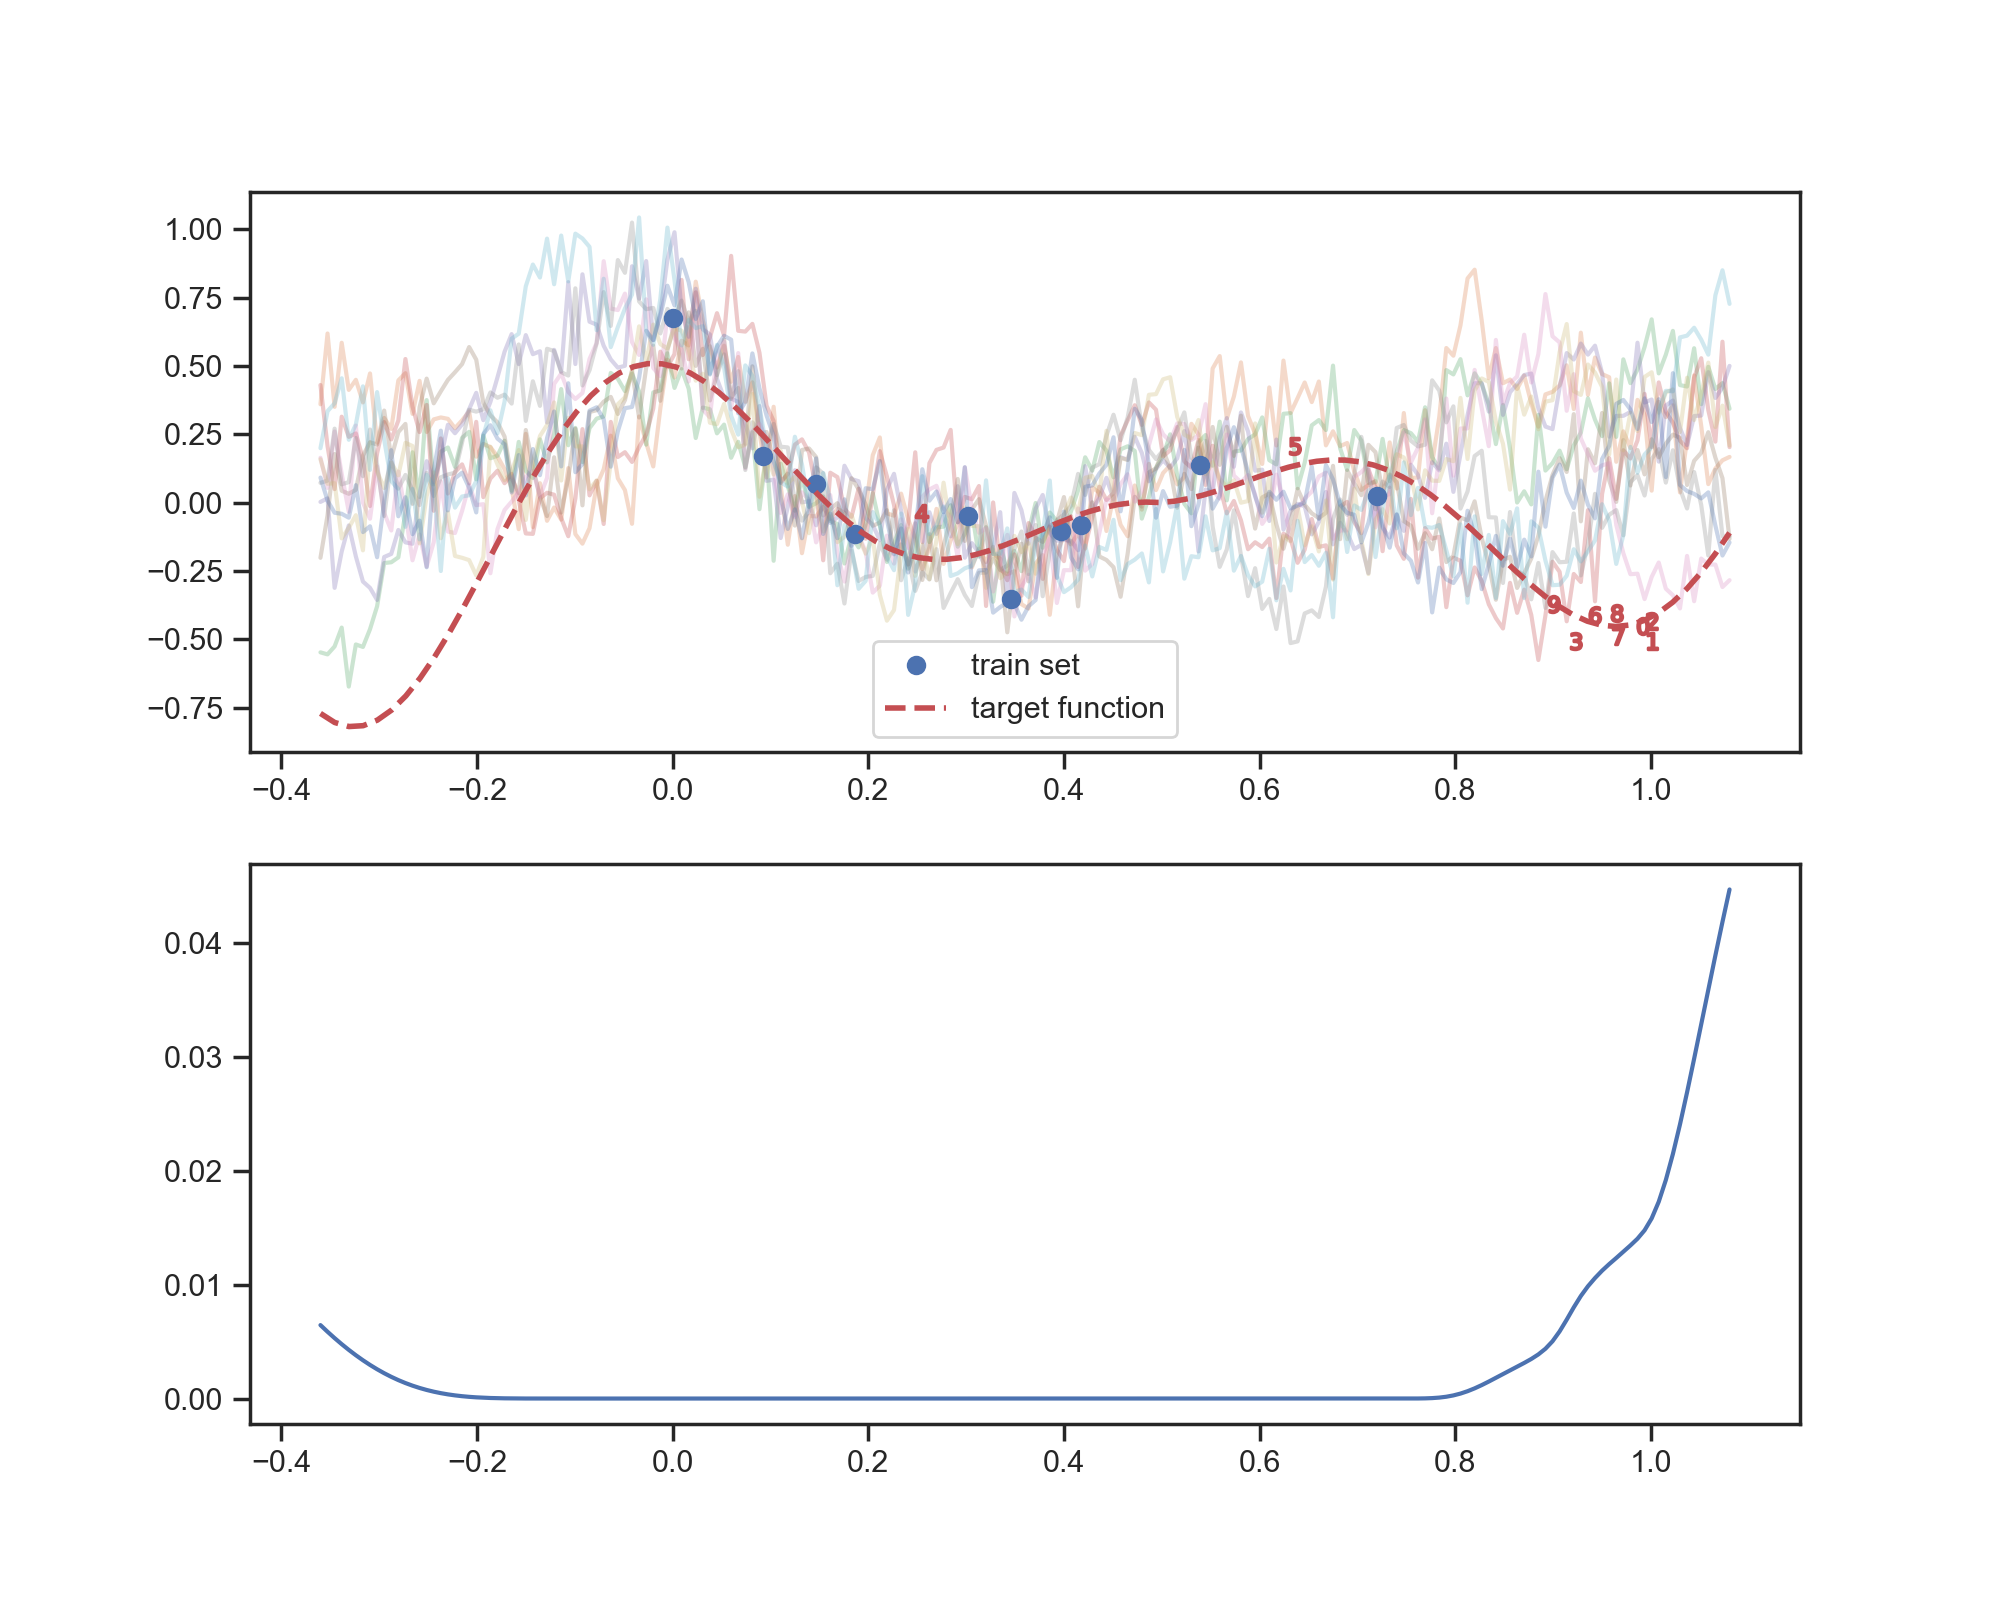

In [72]:
seed = 1

# Fix a target function
target = lambda x: np.abs(x-1/2)*np.cos(10*x)
noise = .1
noisy_target = lambda x: target(x) + noise*npr.randn(len(x)).reshape(x.shape)

# Generate data
sample_size = 10
dimension = 1
X, y = nr.generate_data(noisy_regressed_function = noisy_target, sample_size = sample_size, 
                        dimension = dimension, seed=seed)

#plt.ion() # Keep the plot open, we wull superimpose a few samples afterwards
fig, ax = plt.subplots(2, figsize=(10,8))
if dimension == 1:
    # Plot training data
    ax[0].plot(X, y, 'o',label="train set")
    
    # Plot target function on top
    delta = np.max(X)-np.min(X)
    plotting_range = (np.min(X)-delta/2, np.max(X)+delta/2)
    xPlot = np.linspace(*plotting_range, 100)
    ax[0].plot(xPlot, target(xPlot), '--', label="target function", color='r', linewidth=2)
    ax[0].legend()
    #plt.show()

*Exercise:* Leave the above plot open. Now implement a `BayesianOptimization` class in the companion Python file. The object, for starters, should 
* take $X$ and $y$ as input, 
* fit the parameters of, say, a Matern kernel,
* output the posterior predictive at a given set of test points. 

Start with using `sklearn`'s GP class, and if you feel like it, remove sklearn once you made everything work.

In [73]:
bo = nr.BayesianOptimization(X, y)
bo.fit() # Fit the GP to the input data

if dimension==1:
    # Visualize the posterior by showing samples on top of the trainsing data above.
    number_of_samples = 10
    xPlot = np.linspace(*plotting_range, 200).reshape((200,1))
    for seed in range(number_of_samples):
        yPlot = bo.sample_y(xPlot, random_state=seed).flatten()
        ax[0].plot(xPlot, yPlot, alpha=.3, zorder=1)
    plt.show()

*Exercise:* keep the plot open, and superimpose an acquisition criterion in the lower subplot.

In [74]:
ax[1].plot(xPlot, bo.acquisition_criterion(xPlot), label='EI')
ax[1].legend()

*Exercise*: Now add methods `find_next_point`and `update` to make the following BO loop work. You should see the added points appear as numbers on the plot above if you left it open. Comment on the behaviour of the algorithm.

In [75]:
bo = nr.BayesianOptimization(X, y)
bo.fit() # Fit the GP to the input data
number_of_iterations = 10

for i in range(number_of_iterations):
    
    # perform one step of BO
    xstar = bo.find_next_point(number_of_restarts = 3) # returns the maximum of your acquisition criterion
    ystar = noisy_target(xstar)
    bo.update(xstar, ystar) # evaluate f at x and add (x, f(x)) to the training sample
    bo.fit() # update parameters of the GP

    # plot the corresponding sample
    ax[0].plot(xstar, ystar, marker='$'+str(i)+'$', color='r')
    ax[1].clear()
    ax[1].plot(xPlot, bo.acquisition_criterion(xPlot), label='EI')

In [71]:
# Close the plot above.
plt.close()

*Bonus exercise:* replace the empirical Bayesian fit of the kernel parameters by a proper MCMC integration. Use `pymc3`. The next point to add to the sample is now optimizing an expected loss. We are still greedy overall instead of solving an (intractable) dynamic programming problem, but this is getting closer to being Bayesian. 